In [1]:
#!pip install prefect[dask] dask-jobqueue
#!pip install dask distributed
#!pip install torchvision
#!conda install pytorch-cpu -y


In [2]:
!prefect config set PREFECT_API_URL="https://ard-modeling-service.slac.stanford.edu/api" 


Set 'PREFECT_API_URL' to 'https://ard-modeling-service.slac.stanford.edu/api'.
Updated profile 'default'.


In [3]:
import urllib.request
import zipfile

In [4]:
filename, _ = urllib.request.urlretrieve("https://download.pytorch.org/tutorial/hymenoptera_data.zip", "data.zip")
zipfile.ZipFile(filename).extractall()

In [3]:
import prefect
from prefect import flow, task, get_run_logger
from prefect_dask import DaskTaskRunner
from dask_jobqueue import SLURMCluster
from dask.distributed import Client


import torchvision
from tutorial_helper import (imshow, train_model, visualize_model, dataloaders, class_names, finetune_model)
import dask
import glob
import toolz
import torch
from torchvision import transforms
from PIL import Image
import pickle

import time

In [16]:
%%time
model = finetune_model()



/global/homes/s/sanjeevc/.local/perlmutter/python-3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/global/homes/s/sanjeevc/.local/perlmutter/python-3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/1
----------
train Loss: 0.8193 Acc: 0.6311
val Loss: 0.3020 Acc: 0.8627

Epoch 1/1
----------
train Loss: 0.4365 Acc: 0.7992
val Loss: 0.2123 Acc: 0.9281

Training complete in 0m 15s
Best val Acc: 0.928105
CPU times: user 2.27 s, sys: 873 ms, total: 3.15 s
Wall time: 15.8 s


array([[<Axes: title={'center': 'Predicted: bees'}>,
        <Axes: title={'center': 'Predicted: bees'}>],
       [<Axes: title={'center': 'Predicted: ants'}>,
        <Axes: title={'center': 'Predicted: bees'}>],
       [<Axes: title={'center': 'Predicted: bees'}>,
        <Axes: title={'center': 'Predicted: bees'}>]], dtype=object)

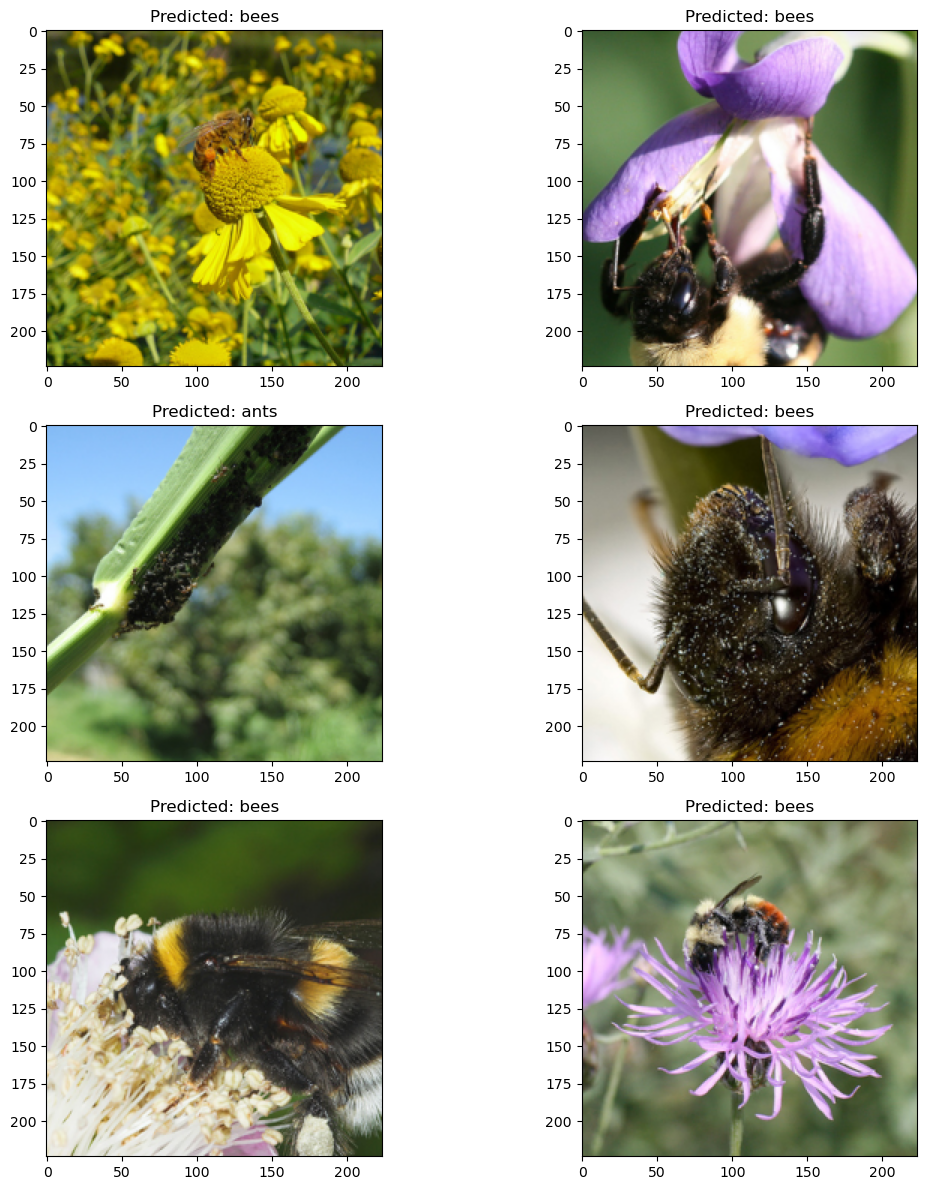

In [17]:
visualize_model(model)


In [4]:
# Define your SLURMCluster with asynchronous=True
cluster_kwargs = {
    "cores": 1,
    "memory": "10GB",
    "shebang": "#!/bin/bash",
    "walltime": "00:10:00",
    "job_script_prologue": ["source ~/.bashrc"],
    "job_extra_directives": ["-A m669", "-q regular", "--constraint=cpu"],
    "asynchronous": True
}
cluster = SLURMCluster(**cluster_kwargs)
cluster.scale(200)  # Adjust the number of workers
client = Client(cluster)


/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34189 instead
  warnings.warn(


18:33:48.075 | INFO    | distributed.scheduler - State start

18:33:48.089 | INFO    | distributed.scheduler -   Scheduler at:  tcp://128.55.64.38:44959

18:33:48.090 | INFO    | distributed.scheduler -   dashboard at:  http://128.55.64.38:34189/status

18:33:48.099 | INFO    | distributed.scheduler - Registering Worker plugin shuffle

In [5]:
client


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://128.55.64.38:34189/status,
Dashboard: http://128.55.64.38:34189/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.55.64.38:44959,Workers: 0
Dashboard: http://128.55.64.38:34189/status,Total threads: 0
Started: Just now,Total memory: 0 B


18:37:10.291 | INFO    | distributed.scheduler - Receive client connection: Client-e3e9f329-6fdd-11ef-8e12-6569865f5fa3

18:37:10.293 | INFO    | distributed.core - Starting established connection to tcp://128.55.64.38:50616

In [10]:
import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image


@dask.delayed
def load(path, fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img


@dask.delayed
def transform(img):
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)

In [11]:
objs = [load(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]


In [12]:
tensors = [transform(x) for x in objs]


In [13]:
batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(10, tensors)]
batches[:5]


[Delayed('stack-b6e9d42c-5e53-47d6-846b-79bb32b07911'),
 Delayed('stack-b784d7bd-7821-48c7-a008-c8311d929321'),
 Delayed('stack-9f3e51b6-9c15-421e-bf09-67aa6b499be3'),
 Delayed('stack-0a475aa7-56b9-447e-a5c7-0ce0fb14df4a'),
 Delayed('stack-401fae59-1842-4bdb-818b-374bec08e9ca')]

05:35:26.524 | INFO    | distributed.http.proxy - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy

/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36271 instead
  warnings.warn(


05:35:26.560 | INFO    | distributed.scheduler - State start

05:35:26.562 | INFO    | distributed.diskutils - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-q2j3_zli', purging

05:35:26.563 | INFO    | distributed.diskutils - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-psq5sx0x', purging

05:35:26.564 | INFO    | distributed.diskutils - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-yon4c4ol', purging

05:35:26.565 | INFO    | distributed.diskutils - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-oqyxeo4i', purging

05:35:26.567 | INFO    | distributed.diskutils - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-7w6vzxl2', purging

05:35:26.577 | INFO    | distributed.scheduler -   Scheduler at:  tcp://128.55.64.24:40077

05:35:26.579 | INFO    | distributed.scheduler -   dashboard at:  http://128.55.64.24:36271/status

In [14]:
@dask.delayed
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

In [15]:
import pickle

dask.utils.format_bytes(len(pickle.dumps(model)))

'42.72 MiB'

In [16]:
dmodel = dask.delayed(model.cpu()) # ensuring model is on the CPU


In [19]:
predictions = [predict(batch, dmodel) for batch in batches]
#dask.visualize(predictions[:2])

In [21]:
predictions = await dask.compute(*predictions)
predictions

/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 42.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


TypeError: 'coroutine' object is not iterable

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
@task
def download_data():
    filename, _ = urllib.request.urlretrieve("https://download.pytorch.org/tutorial/hymenoptera_data.zip", "data.zip")
    zipfile.ZipFile(filename).extractall()

@task
def finetune_model_task():
    model = finetune_model()
    return model

@task
def load_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img

@task
def transform_image(img):
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)

@task
def predict_batch(batch, model):
    batch = torch.stack(batch)  # Ensure batch is a tensor

    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

In [ ]:
@flow(task_runner=DaskTaskRunner(cluster=cluster))
def batch_prediction_flow():
    # Download data
    download_data()

    # Finetune model
    model = finetune_model_task()

    # Load and transform images
    image_paths = glob.glob("hymenoptera_data/val/*/*.jpg")
    images = [load_image(path) for path in image_paths]
    tensors = [transform_image(img) for img in images]

    # Stack tensors into batches
    batches = [dask.delayed(torch.stack)(batch) for batch in toolz.partition_all(10, tensors)]

    # Predict using the model
    dmodel = dask.delayed(model.cpu())  # ensuring model is on the CPU
    predictions = [predict_batch(batch, dmodel) for batch in batches]
    
    # Compute predictions
    predictions = dask.compute(*predictions)
    print(predictions)

In [ ]:
# Run the flow
%time
batch_prediction_flow()